In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tabulate import tabulate
layers = tf.keras.layers
import warnings
warnings.filterwarnings('ignore')

In [2]:
tf.keras.utils.set_random_seed(1917) #For reproducibility

The code block below defines a few helper functions to visualize the results. You do not need to touch them.

In [3]:
def plot_examples(X, Y, n=10):
    """ Plot the first n examples for each of the 10 classes in the CIFAR dataset X, Y """
    fig, axes = plt.subplots(n, 10, figsize=(10, n))
    for l in range(10):
        axes[0, l].set_title(cifar10_labels[l], fontsize="smaller")
        m = np.squeeze(Y) == l  # boolean mask: True for all images of label l
        for i in range(n):
            image = X[m][i].astype("uint8")  # imshow expects uint8
            ax = axes[i, l]
            ax.imshow(image, origin="upper")
            ax.set(xticks=[], yticks=[])
    return fig, ax


def plot_prediction(X, Y, Y_predict):
    """
    Plot image X along with predicted probabilities Y_predict.
    X: CIFAR image, shape = (32, 32, 3)
    Y: CIFAR label, one-hot encoded, shape = (10)
    Y_predict: predicted probabilities, shape = (10)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    # plot image
    ax1.imshow(X.astype("uint8"), origin="upper")
    ax1.set(xticks=[], yticks=[])

    # plot probabilities
    ax2.barh(np.arange(10), Y_predict, align="center")
    ax2.set(xlim=(0, 1), xlabel="Score", yticks=[])
    for i in range(10):
        c = "red" if (i == np.argmax(Y)) else "black"
        ax2.text(0.05, i, cifar10_labels[i].capitalize(), ha="left", va="center", color=c)



def plot_confusion(Y_true, Y_predict):
    """
    Plot confusion matrix
    Y_true:    array of true classifications (0-9), shape = (N)
    Y_predict: array of predicted classifications (0-9), shape = (N)
    """
    C = np.histogram2d(Y_true, Y_predict, bins=np.linspace(-0.5, 9.5, 11))[0]
    Cn = C / np.sum(C, axis=1)

    fig = plt.figure()
    plt.imshow(Cn, interpolation="nearest", vmin=0, vmax=1, cmap=plt.cm.YlGnBu)
    plt.colorbar()
    plt.xlabel("prediction")
    plt.ylabel("truth")
    plt.xticks(range(10), cifar10_labels, rotation="vertical")
    plt.yticks(range(10), cifar10_labels)
    for x in range(10):
        for y in range(10):
            plt.annotate("%i" % C[x, y], xy=(y, x), ha="center", va="center")



First we load and preprocess CIFAR-10 data. The imagages are 32x32 pixels and have three color channels (red, green blue).

In [4]:
# X: images, Y: labels
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("images, shape = ", x_train.shape)
print("labels, shape = ", y_train.shape)

cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

images, shape =  (50000, 32, 32, 3)
labels, shape =  (50000, 1)


In [5]:
# convert labels ("0"-"9") to one-hot encodings, "0" = (1, 0, ... 0) and so on
y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 10)[:8000]
y_valid_onehot = tf.keras.utils.to_categorical(y_test, 10)[8000:]

# Hint: normalize the data
# Normalize
x_train_norm = x_train / 255
x_test_norm = x_test / 255

# Hint: use 20% of the training data for validation
x_valid_norm = x_test_norm[8000:]
x_test_norm = x_test_norm[:8000]

print("x_train shape:", x_train_norm.shape)
print(x_train_norm.shape[0], "train samples")
print(x_valid_norm.shape[0], "validation samples")
print(x_test_norm.shape[0], "test samples")
print("\ny_train shape:", y_train.shape)
print(y_train_onehot.shape[0], "train samples")
print(y_valid_onehot.shape[0], "validation samples")
print(y_test_onehot.shape[0], "test samples")

x_train shape: (50000, 32, 32, 3)
50000 train samples
2000 validation samples
8000 test samples

y_train shape: (50000, 1)
50000 train samples
2000 validation samples
8000 test samples


In [6]:
def dense_block(x, n=16):
    """ Create a block of n densely connected pairs of convolutions """
    xlist = [x]
    for i in range(n):
        x = layers.Conv2D(8, (3, 3), padding='same', activation='relu')(x)
        xlist.append(x)
        x = layers.concatenate(xlist[:], axis=-1)
    return x

In [7]:
#x0 = layers.Input(shape=x_train_norm.shape, name='input')
x0 = layers.Input(shape=(32,32,3), name='input')
x = dense_block(x0)
x = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
x = layers.AveragePooling2D((2, 2), strides=(2, 2))(x)
x = dense_block(x)
x = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)#
x = layers.AveragePooling2D((2, 2), strides=(2, 2))(x)#
x = dense_block(x)#
x = layers.GlobalAveragePooling2D(name='final_globalpooling')(x)
x = layers.Dense(10, activation='softmax')(x)
model = tf.keras.models.Model(inputs=[x0], outputs=[x], name='DenseNet')

In [8]:
# ----------------------------------------------------------
# Training
# ----------------------------------------------------------
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), # For M1/M2 macs works better
    #optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), # keras 3
    metrics=['accuracy']
)

model.fit(
    x_train_norm,
    y_train_onehot,
    batch_size=128,
    epochs=40,
    validation_data=(x_valid_norm, y_valid_onehot),
    callbacks=[tf.keras.callbacks.CSVLogger("history_cnn.csv".format(model.name))],
    verbose = 1
)

Epoch 1/40


2025-11-28 13:01:23.529414: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


391/391 [==============================] - 97s 235ms/step - loss: 1.7506 - accuracy: 0.3402 - val_loss: 1.5145 - val_accuracy: 0.4305
Epoch 2/40
391/391 [==============================] - 91s 232ms/step - loss: 1.3278 - accuracy: 0.5137 - val_loss: 1.3684 - val_accuracy: 0.5140
Epoch 3/40
391/391 [==============================] - 96s 246ms/step - loss: 1.0799 - accuracy: 0.6123 - val_loss: 1.0316 - val_accuracy: 0.6265
Epoch 4/40
391/391 [==============================] - 96s 246ms/step - loss: 0.9083 - accuracy: 0.6764 - val_loss: 0.8940 - val_accuracy: 0.6655
Epoch 5/40
391/391 [==============================] - 94s 241ms/step - loss: 0.8074 - accuracy: 0.7145 - val_loss: 0.8796 - val_accuracy: 0.6785
Epoch 6/40
391/391 [==============================] - 90s 229ms/step - loss: 0.7122 - accuracy: 0.7491 - val_loss: 0.7120 - val_accuracy: 0.7460
Epoch 7/40
391/391 [==============================] - 89s 229ms/step - loss: 0.6379 - accuracy: 0.7768 - val_loss: 0.7108 - val_accuracy: 0.7

In [9]:
nb_nodes = 256
print("Model performance :")
headers = ["", "Loss", "Accuracy", "Test error rate [%]"]

table = [
    [
        "Train",
        *model.evaluate(x_train_norm, y_train_onehot, verbose=0, batch_size=nb_nodes),
        (1 - model.evaluate(x_train_norm, y_train_onehot, verbose=0, batch_size=nb_nodes)[1])
        * 100,
    ],
    [
        "Validation",
        *model.evaluate(x_valid_norm, y_valid_onehot, verbose=0, batch_size=nb_nodes),
        (1 - model.evaluate(x_valid_norm, y_valid_onehot, verbose=0, batch_size=nb_nodes)[1])
        * 100,
    ],
    [
        "Test",
        *model.evaluate(x_test_norm, y_test_onehot, verbose=0, batch_size=nb_nodes),
        (1 - model.evaluate(x_test_norm, y_test_onehot, verbose=0, batch_size=nb_nodes)[1]) * 100,
    ],
]

print(tabulate(table, headers=headers, tablefmt="orgtbl"))

Model performance :
|            |      Loss |   Accuracy |   Test error rate [%] |
|------------+-----------+------------+-----------------------|
| Train      | 0.0663138 |   0.97656  |                2.344  |
| Validation | 1.00954   |   0.807    |               19.3    |
| Test       | 0.97548   |   0.812625 |               18.7375 |


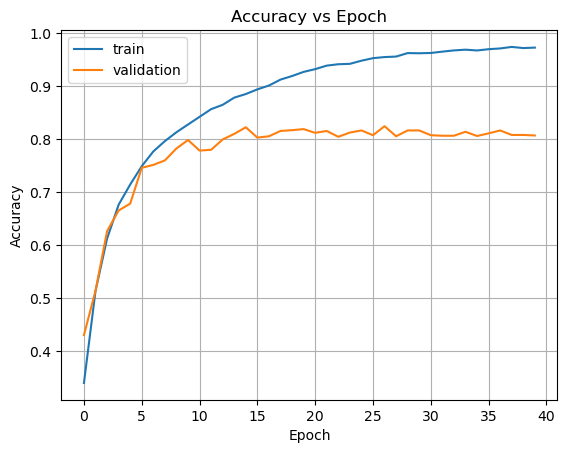

In [10]:
# training curves
history = np.genfromtxt("history_cnn.csv".format(model.name), delimiter=",", names=True)

fig, ax = plt.subplots()
ax.plot(history['accuracy'])
ax.plot(history['val_accuracy'])
ax.set(xlabel="Epoch", ylabel="Accuracy", title="Accuracy vs Epoch")
ax.grid(True)
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

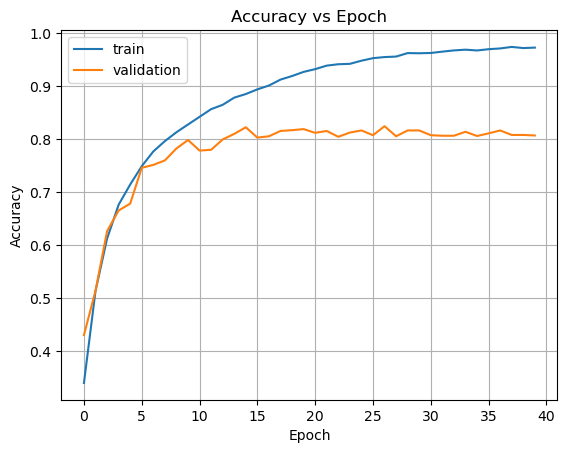

In [11]:
# training curves
history = np.genfromtxt("history_cnn.csv".format(model.name), delimiter=",", names=True)

fig, ax = plt.subplots()
ax.plot(history['accuracy'])
ax.plot(history['val_accuracy'])
ax.set(xlabel="Epoch", ylabel="Accuracy", title="Accuracy vs Epoch")
ax.grid(True)
ax.legend(['train', 'validation'], loc='upper left')

plt.show()

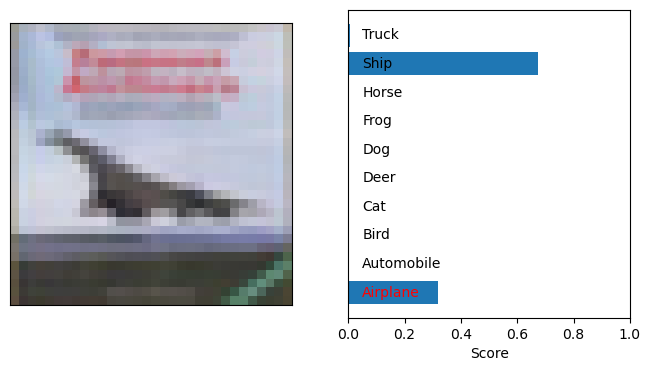

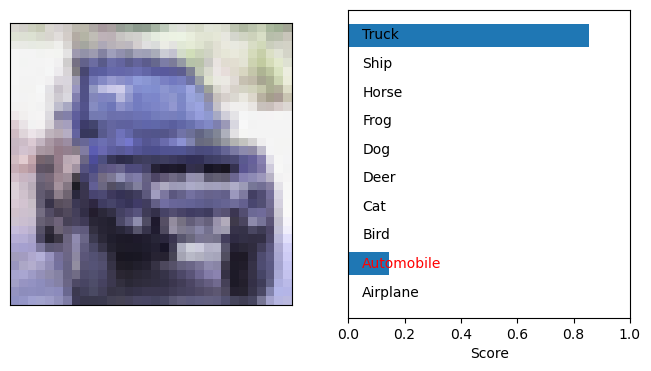

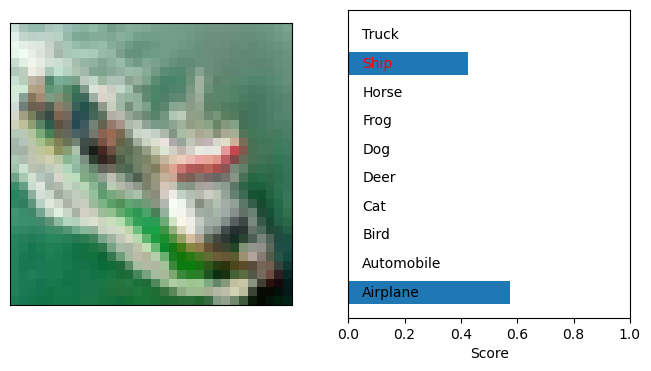

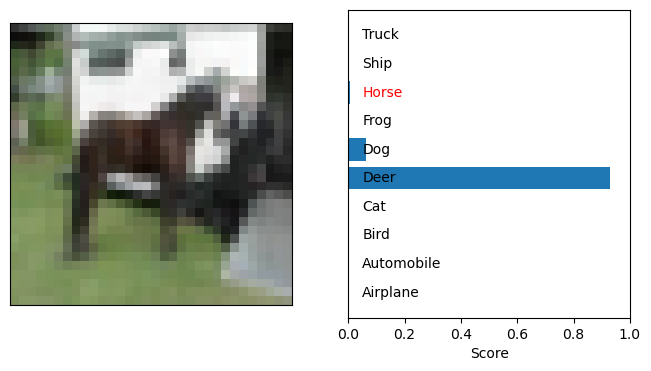

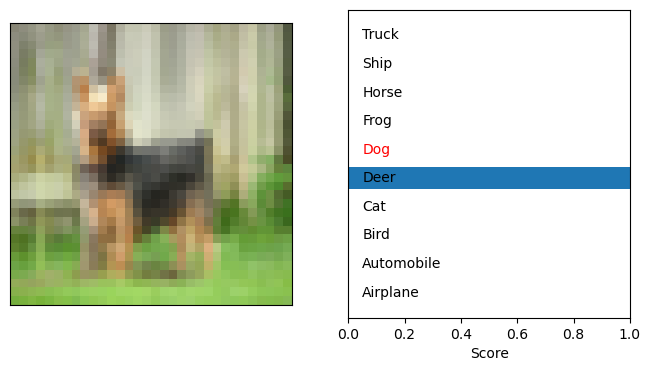

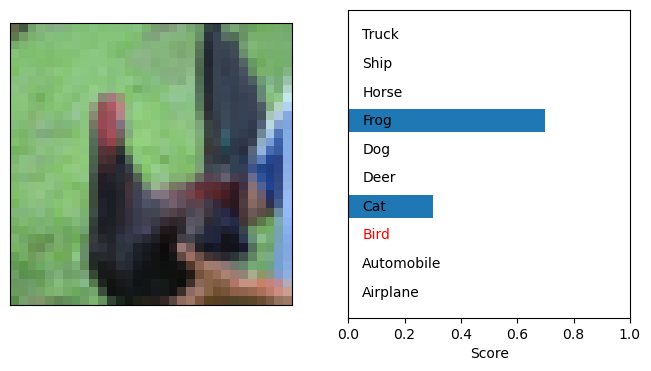

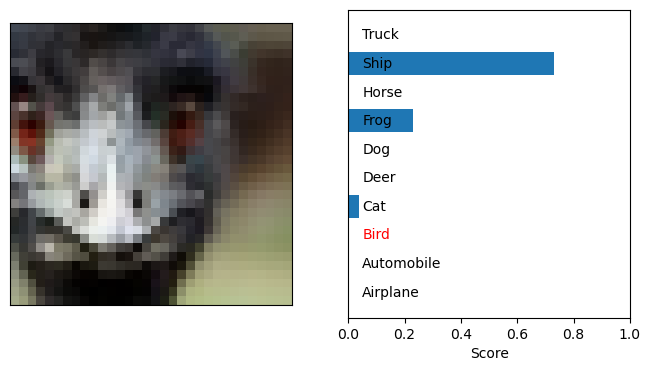

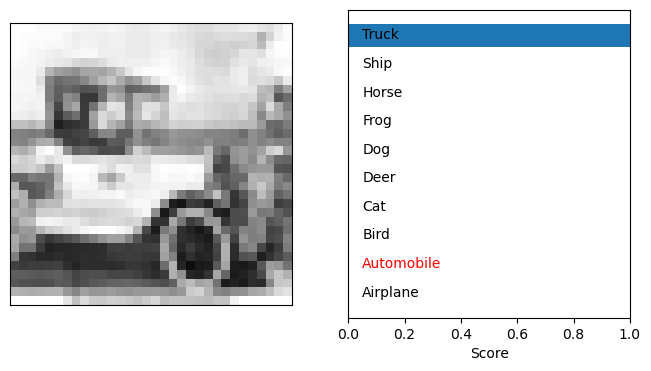

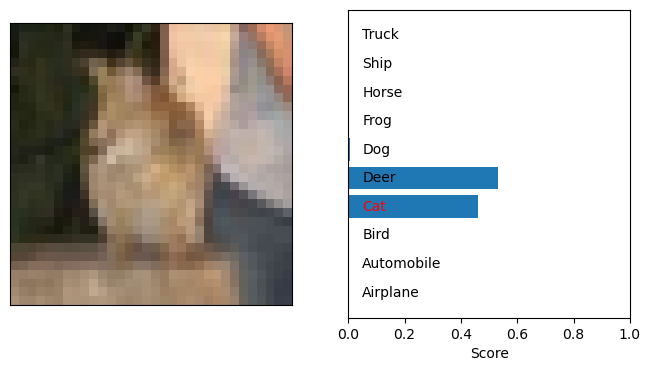

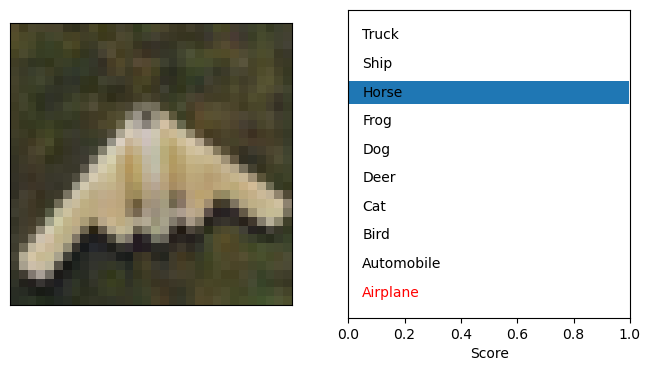

In [12]:
# calculate predictions for test set
y_predict = model.predict(x_test_norm, batch_size=128, verbose=0)

# convert back to class labels (0-9)
y_predict_cl = np.argmax(y_predict, axis=1)
y_test_cl = np.argmax(y_test_onehot, axis=1)

# Task: plot a few examples of correctly and incorrectly classified images.
# Hint: First find the indices of correctly and incorrectly classified images:
m = y_predict_cl == y_test_cl
i0 = np.arange(8000)[~m]  # misclassified images
i1 = np.arange(8000)[m]  # correctly classified images

# original (unnormalized) test images
x_test = x_test[:8000]

# Hint: Now you can use the `plot_prediction` function to plot the images:
# plot first 10 false classifications
for i in i0[0:10]:
    plot_prediction(x_test[i], y_test_onehot[i], y_predict[i])

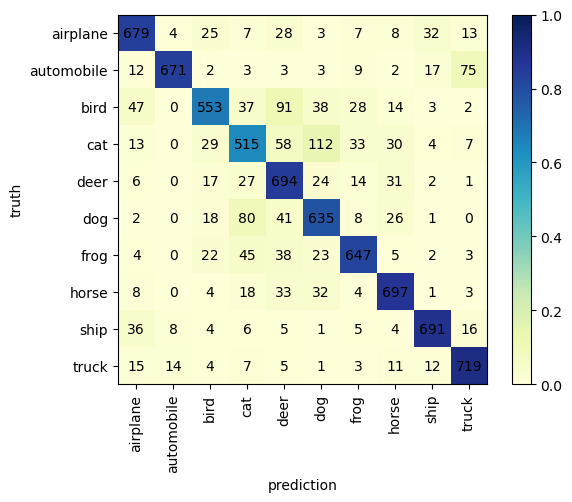

In [13]:
# plot confusion matrix
plot_confusion(y_test_cl, y_predict_cl)

# Observations/Remarks

* Our previous results for the CNN had a loss of 0.844429, an accuracy of 0.718125 and an error rate of 28.1875 for the test data. As such since here we have a loss of 0.97548, an accuracy of 0.812625 and en error of 18.7375 over the test data. It is clear that this DenseNet model outperforms the CNN used previously

* Moreover, from the Accuracy vs Epoch plot it is observed that the DenseNet network overfits more the train data. Let's remember that from the results of the simple CNN both the train and validation behaved relatively the same. Nonetheless, despite the overfitting in DenseNet, the validation and test accuracy it’s higher. Still really good results are obtained.
